Building a Logistic Regression Classifier

In [35]:
#Read the train data
import pandas as pd
from numba import jit

data = pd.read_csv('asylum_clean.csv')
#data # 501053 rows

In [36]:
# Check if there is duplicated 'idncase' 
data_duplicated = data.duplicated('idncase', keep =False)
data_duplicated[data_duplicated==True]

# Visualize data sorted by 'idncase' and 'idnproceeding'
data_duplicated_sorted = data[data_duplicated].sort_values(by=['idncase', 'idnproceeding'])

In [37]:
# Check for missing values by column 'grant'
data['grant'].isnull().values.any() # there are missing values!

# Check for missing values by column 'grantraw'
data['grantraw'].isnull().values.any() # no NaN value
data[data['grantraw']==1] # 167912 rows with 'grantraw'==1
data[data['grantraw']==0] # 311681 rows with 'grantraw'==0 No missing values!

# Check for missing values by column 'hearing_loc_code'
data['hearing_loc_code'].isnull().values.any() # No missing values!
data['hearing_loc_code'].unique()
data['hearing_loc_code'].unique().shape # 247 unique locations

# Check for missing values by column 'natid'
data['natid'].isnull().values.any() # There are missing values!
data['natid'].unique()
data['natid'].unique().shape # 227 unique natid including 'NaN'
data['natid'].isnull().sum() # 337 rows with missing values on column 'natid'

# Prepare data for basic Log Reg using features 'hearing_loc_code', 'natid', and 'grantraw' as X
data_X = data[['hearing_loc_code', 'natid', 'grantraw']]

# Remove 337 rows where 'natid' has missing values
data_X = data_X.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

In [38]:
# Convert categorical data from "hearing_loc_code" into dummy variables
import numpy as np
unique_hearing_loc_code = data_X.hearing_loc_code.unique()
for u in unique_hearing_loc_code:
    data_X[u] = np.where(data_X['hearing_loc_code']== u, 1, 0)

In [39]:
# Convert categorical data from "natid" into dummy variables
unique_natid = data_X.natid.unique()
for n in unique_natid:
    data_X[int(n)] = np.where(data_X['natid']== int(n), 1, 0)

In [44]:
# Drop columns "natid" and "hearing_loc_code"
data_X = data_X.drop(["natid","hearing_loc_code"], axis=1)

In [45]:
# Random split into train and test
import random

np.random.seed(seed=0)
new_index = range(data_X.shape[0])
np.random.shuffle(new_index)

train = data_X.iloc[new_index[0:int(data_X.shape[0]*.8)]]
test = data_X.iloc[new_index[int(data_X.shape[0]*.8)]:]

In [46]:
train.shape # 383673 rows
test.shape # 95583 rows

(138304, 475)

In [47]:
# Implement Log Reg
from sklearn import linear_model

logreg = linear_model.LogisticRegression(C = 1e30)
logreg.fit(train.drop('grantraw', 1), train['grantraw'])

LogisticRegression(C=1e+30, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

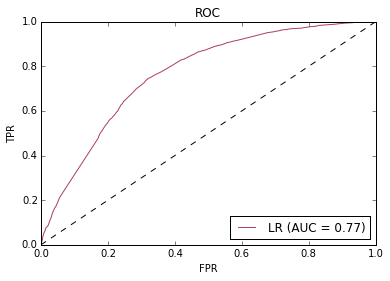

In [48]:
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
%matplotlib inline

@jit
def plotAUC(truth, pred, lab):
    fpr, tpr, thresholds = roc_curve(truth, pred)
    roc_auc = auc(fpr, tpr)
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color=c, label= lab+' (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")
    
plotAUC(test['grantraw'], logreg.predict_proba(test.drop('grantraw', 1))[:,1], 'LR')  

plt.show()